In [21]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from collections import Counter
from imblearn.combine import SMOTEENN

In [22]:
stroke_raw_df = pd.read_csv("stroke_raw_df.csv", index_col=0)
stroke_norm_df = pd.read_csv("stroke_norm_df.csv", index_col=0)
stroke_scaled_df = pd.read_csv("stroke_scaled_df.csv", index_col=0)

### Working with the raw data (not normalized or scaled)

In [23]:
stroke_raw_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,1,0,0
1,51676,0,61.0,0,0,1,0,202.21,33.2,1,0,0,1,0,0,1,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0,0,0,1
4,1665,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,1,0


In [29]:
to_drop = stroke_raw_df[['stroke', 'id']]
X = stroke_raw_df.drop(to_drop, axis=1)
y = stroke_raw_df['stroke']


# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
print('Original dataset shape %s' % Counter(y_train))
print('Original dataset test shape %s' % Counter(y_test))

Original dataset shape Counter({0: 2443, 1: 173})
Original dataset test shape Counter({0: 1048, 1: 74})


#### Random Forest on the dataset before resampling
Used GridSearchCV to identify the best hyperparameters for all models

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(random_state=42)

#define a grid of hyperparameters
params_rfc = {
    'n_estimators': [100,300,400,500],
    'max_depth': [4,6,8],
    'min_samples_leaf': [0.1,0.2,0.05],
    'max_features': ['log2','sqrt']
}

# instantiate grid_rfc
grid_rfc = GridSearchCV(estimator=rfc,
                        param_grid=params_rfc,
                       cv=3,
                       scoring= 'accuracy',
                       verbose=1,
                       n_jobs=-1)
# fit grid_rfc to training set
grid_rfc.fit(X_train, y_train)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 100}


In [31]:
# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_train, y_train)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

print('Random forest classification')
print(classification_report(y_test, y_pred))

Train set accuracy score of rfc: 0.933868501529052
Test set accuracy score of rfc: 0.9340463458110517
Random forest classification
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1048
           1       0.00      0.00      0.00        74

    accuracy                           0.93      1122
   macro avg       0.47      0.50      0.48      1122
weighted avg       0.87      0.93      0.90      1122



/Users/brittanyminor/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyminor/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brittanyminor/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Our dataset is very imbalanced and the participants with strokes are the minority class so it is not surprising that it was unable to predict any strokes.

#### Run feature importances with the random forest classifier to see which features are providing the most importance in the prediction.

In [33]:
rfc.fit(X_train, y_train)
feature_imp = pd.Series(rfc.feature_importances_,index=stroke_raw_df.drop(to_drop, axis =1).columns).sort_values(ascending=False)
print(feature_imp)
print(rfc.n_features_)

avg_glucose_level                 0.274942
age                               0.243674
bmi                               0.232576
Residence_type                    0.032539
gender                            0.032048
heart_disease                     0.026855
hypertension                      0.025250
work_type_Private                 0.018966
ever_married                      0.018849
smoking_status_never smoked       0.017710
smoking_status_Unknown            0.017413
smoking_status_formerly smoked    0.016785
work_type_Self-employed           0.016499
smoking_status_smokes             0.014722
work_type_Govt_job                0.011170
dtype: float64
15


In [34]:
X = stroke_raw_df[['avg_glucose_level','age','bmi']]
y= stroke_raw_df['stroke']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
print('Original dataset shape %s' % Counter(y_train))
print('Original dataset test shape %s' % Counter(y_test))

Original dataset shape Counter({0: 2443, 1: 173})
Original dataset test shape Counter({0: 1048, 1: 74})


### SMOTEN with fewer features-- just the top 3 most important
SMOTEN creates new data points in the minority class with interpolation

In [37]:
from imblearn.over_sampling import SMOTEN
smoten = SMOTEN(random_state=42)
X_smote, y_smote = smoten.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_smote))

rfc= RandomForestClassifier(random_state=42)

#define a grid of hyperparameters
params_rfc = {
    'n_estimators': [100,300,400,500],
    'max_depth': [4,6,8],
    'min_samples_leaf': [0.1,0.2,0.05],
    'max_features': ['log2','sqrt']
}

# instantiate grid_rfc
grid_rfc = GridSearchCV(estimator=rfc,
                        param_grid=params_rfc,
                       cv=3,
                       scoring= 'accuracy',
                       verbose=1,
                       n_jobs=-1)
# fit grid_rfc to training set
grid_rfc.fit(X_smote, y_smote)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)

# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_smote, y_smote)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))

Resampled dataset shape Counter({0: 2443, 1: 2443})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Train set accuracy score of rfc: 0.8419975440032746
Test set accuracy score of rfc: 0.8155080213903744

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.86      0.14      0.90      0.34      0.13      1048
          1       0.07      0.14      0.86      0.09      0.34      0.11        74

avg / total       0.88      0.82      0.18      0.84      0.34      0.12      1122



### Random Oversample with fewer features- just the top 3 most important
Random oversampling duplicates random datapoints from the minority class to improve the balance in the dataset

In [38]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res= ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

# fit grid_rfc to training set
grid_rfc.fit(X_res, y_res)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)



# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_res, y_res)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))

Resampled dataset shape Counter({0: 2443, 1: 2443})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 0.05, 'n_estimators': 400}
Train set accuracy score of rfc: 0.7531723291035612
Test set accuracy score of rfc: 0.6898395721925134

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.68      0.77      0.80      0.73      0.52      1048
          1       0.15      0.77      0.68      0.25      0.73      0.53        74

avg / total       0.92      0.69      0.76      0.77      0.73      0.52      1122




## Random oversample with more features
Because Random Forest automatically uses the square root of the total number of features as the default number of features, I have gone back to using the full set of features. When only using the top 3 features, that leaves fewer features to pull from for each tree. You can specify the number of features using an integer but that would reduce the randomness added to the Random Forest because each tree would be using the same features.

In [39]:
to_drop = stroke_raw_df[['stroke', 'id']]
X = stroke_raw_df.drop(to_drop, axis=1)
y = stroke_raw_df['stroke']


# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
print('Original dataset shape %s' % Counter(y_train))
print('Original dataset test shape %s' % Counter(y_test))

Original dataset shape Counter({0: 2443, 1: 173})
Original dataset test shape Counter({0: 1048, 1: 74})


In [41]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res= ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

# fit grid_rfc to training set
grid_rfc.fit(X_res, y_res)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)



# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_res, y_res)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))

Resampled dataset shape Counter({0: 2443, 1: 2443})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Train set accuracy score of rfc: 0.7482603356528857
Test set accuracy score of rfc: 0.679144385026738

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.67      0.81      0.80      0.74      0.54      1048
          1       0.15      0.81      0.67      0.25      0.74      0.55        74

avg / total       0.93      0.68      0.80      0.76      0.74      0.54      1122



[[702 346]
 [ 14  60]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9293993490657232, 0.6676219218381476),
  ('0', '1'): (0.0,
   0.6709441809743603,
   0.9293993490657232,
   0.3290558190256397),
  ('1', '0'): (0.9343744734438326,
   0.0,
   0.06562552655616745,
   0.18856065367693278),
  ('1', '1'): (0.9343744734438326,
   0.1918829128131454,
   0.06562552655616745,
   0.8081170871868547)})

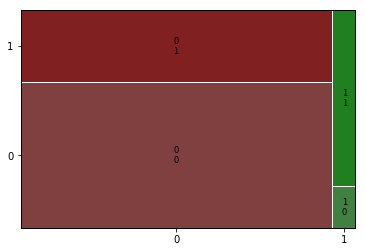

In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
from statsmodels.graphics.mosaicplot import mosaic
mosaic(conf_matrix)

### Basic SMOTENC
SMOTENC - is specifically designed for use with datasets that have both continuous and categorical data
It uses interpolation to create new data points for oversampling the minority class.

In [45]:
# instantiate a SMOTENC object
from imblearn.over_sampling import SMOTENC
smote_enc = SMOTENC(categorical_features = [0,2,3,4,5,8,9,10,11,12,13,14], random_state=42)
X_smotenc, y_smotenc = smote_enc.fit_resample(X_train, y_train)

# Split into training and test set
#X_train, X_test, y_train, y_test = train_test_split(X_smotenc, y_smotenc, test_size = 0.3, random_state=42, stratify=y)

print('Resampled dataset shape %s' % Counter(y_smotenc))

Resampled dataset shape Counter({0: 2443, 1: 2443})


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 0.05, 'n_estimators': 100}
Resampled dataset shape Counter({0: 2443, 1: 2443})
Train set accuracy score of rfc: 0.7681129758493656
Test set accuracy score of rfc: 0.7040998217468806

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.71      0.65      0.82      0.68      0.46      1048
          1       0.14      0.65      0.71      0.22      0.68      0.46        74

avg / total       0.91      0.70      0.65      0.78      0.68      0.46      1122

[[742 306]
 [ 26  48]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9293993490657232, 0.7056630569856204),
  ('0', '1'): (0.0, 0.708985316121833, 0.9293993490657232, 0.2910146838781669),
  ('1', '0'): (0.9343744734438326,
   0.0,
   0.06562552655616745,
   0.35018407111430366),
  ('1', '1'): (0.9343744734438326,
   0.3535063302505163,
   0.06562552655616745,
   0.6464936697494836)})

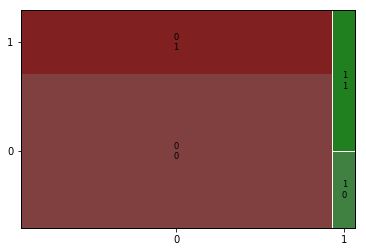

In [46]:
# fit grid_rfc to training set
grid_rfc.fit(X_smotenc, y_smotenc)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)

print('Resampled dataset shape %s' % Counter(y_smotenc))

# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_smotenc, y_smotenc)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))

print('')
print(classification_report_imbalanced(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)

### Combine SMOTENC and Random under
Random undersampling removes a random sample of data points from the majority class

Resampled dataset shape Counter({0: 2443, 1: 2198})
Resampled dataset shape Counter({0: 2198, 1: 2198})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train set accuracy score of rfc: 0.7616014558689718
Test set accuracy score of rfc: 0.7049910873440285

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.71      0.68      0.82      0.69      0.48      1048
          1       0.14      0.68      0.71      0.23      0.69      0.48        74

avg / total       0.91      0.70      0.68      0.78      0.69      0.48      1122

[[741 307]
 [ 24  50]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9293993490657232, 0.7047120286069336),
  ('0', '1'): (0.0,
   0.7080342877431463,
   0.9293993490657232,
   0.2919657122568537),
  ('1', '0'): (0.9343744734438326,
   0.0,
   0.06562552655616745,
   0.3232468348747418),
  ('1', '1'): (0.9343744734438326,
   0.32656909401095446,
   0.06562552655616745,
   0.6734309059890454)})

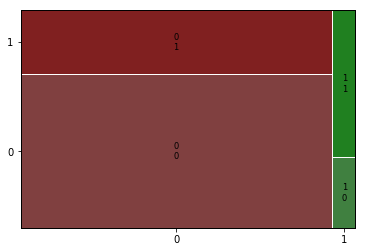

In [48]:
smote_enc = SMOTENC(categorical_features = [0,2,3,4,5,8,9,10,11,12,13,14], random_state=42, sampling_strategy = 0.9)
X_smotenc, y_smotenc = smote_enc.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_smotenc))

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_smunder, y_smunder = rus.fit_resample(X_smotenc, y_smotenc)
print('Resampled dataset shape %s' % Counter(y_smunder))

grid_rfc.fit(X_smunder, y_smunder)

# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_smunder, y_smunder)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))

print('')
print(classification_report_imbalanced(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)

## Random over and under

Resampled dataset shape Counter({0: 2198, 1: 2198})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train set accuracy score of rfc: 0.7488626023657871
Test set accuracy score of rfc: 0.6711229946524064

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.66      0.81      0.79      0.73      0.53      1048
          1       0.14      0.81      0.66      0.25      0.73      0.54        74

avg / total       0.93      0.67      0.80      0.75      0.73      0.53      1122

[[693 355]
 [ 14  60]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9293993490657232, 0.6590626664299662),
  ('0', '1'): (0.0,
   0.6623849255661788,
   0.9293993490657232,
   0.3376150744338211),
  ('1', '0'): (0.9343744734438326,
   0.0,
   0.06562552655616745,
   0.18856065367693278),
  ('1', '1'): (0.9343744734438326,
   0.1918829128131454,
   0.06562552655616745,
   0.8081170871868547)})

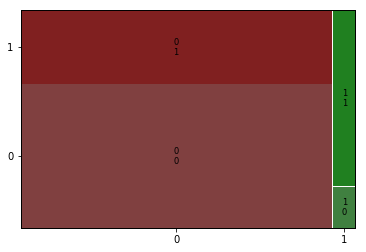

In [49]:
ros = RandomOverSampler(random_state=42, sampling_strategy = 0.9)
X_res, y_res= ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_smunder, y_smunder = rus.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_smunder))

grid_rfc.fit(X_smunder, y_smunder)

# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_smunder, y_smunder)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))

print('')
print(classification_report_imbalanced(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)

## Different Split for train test with random oversampling
I tried using a different split so that I would have a larger set of test data

In [50]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify=y)
print('Original dataset shape %s' % Counter(y_train))
print('Original dataset test shape %s' % Counter(y_test))

Original dataset shape Counter({0: 2094, 1: 148})
Original dataset test shape Counter({0: 1397, 1: 99})


Resampled dataset shape Counter({1: 2094, 0: 2094})
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train set accuracy score of rfc: 0.7492836676217765
Test set accuracy score of rfc: 0.6925133689839572

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.68      0.82      0.81      0.75      0.55      1397
          1       0.15      0.82      0.68      0.26      0.75      0.57        99

avg / total       0.93      0.69      0.81      0.77      0.75      0.55      1496

[[955 442]
 [ 18  81]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9291776412057361, 0.6813366088224172),
  ('0', '1'): (0.0,
   0.6846588679586298,
   0.9291776412057361,
   0.31534113204137004),
  ('1', '0'): (0.9341527655838456,
   0.0,
   0.06584723441615452,
   0.18121413470250683),
  ('1', '1'): (0.9341527655838456,
   0.18453639383871945,
   0.06584723441615452,
   0.8154636061612807)})

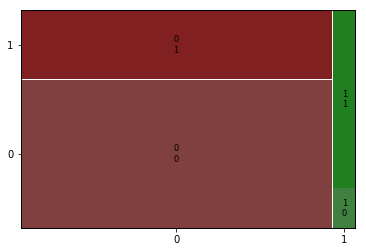

In [51]:
ros = RandomOverSampler(random_state=42)
X_res, y_res= ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))
grid_rfc.fit(X_res, y_res)

# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_res, y_res)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)

# Best performer
This model has the best recall for participants with stroke. Although the precision is low, we believe that it is more important to have higher recall (higher true positives) with more false positives than to have a large number of false negatives. The use case for this model would be to identify participants/patients who would be at a higher risk for stroke. It would be more concerning to miss people who could be counseled on reducing their risk of stroke than to counsel people on reducing risk who don't have as high of risk.

## New GridSearch with the 60/40 train test split and Random oversample

In [55]:
rfc= RandomForestClassifier(random_state=42)

#define a grid of hyperparameters
params_rfc = {
    'n_estimators': [100,300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6],
    'min_samples_leaf': [0.1,0.2,0.05],
    'max_features': ['log2','sqrt']
}

# instantiate grid_rfc
grid_rfc = GridSearchCV(estimator=rfc,
                        param_grid=params_rfc,
                       cv=3,
                       scoring= 'accuracy',
                       verbose=1,
                       n_jobs=-1)
# fit grid_rfc to training set
grid_rfc.fit(X_res, y_res)
#extract best hyperparameters

best_hyperparams = grid_rfc.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 0.05, 'n_estimators': 300}


Train set accuracy score of rfc: 0.7497612225405922
Test set accuracy score of rfc: 0.6971925133689839

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.69      0.83      0.81      0.75      0.56      1397
          1       0.16      0.83      0.69      0.27      0.75      0.58        99

avg / total       0.93      0.70      0.82      0.77      0.75      0.56      1496

[[961 436]
 [ 17  82]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9291776412057361, 0.6856172576736576),
  ('0', '1'): (0.0,
   0.6889395168098701,
   0.9291776412057361,
   0.3110604831901298),
  ('1', '0'): (0.9341527655838456,
   0.0,
   0.06584723441615452,
   0.17114668277458972),
  ('1', '1'): (0.9341527655838456,
   0.17446894191080234,
   0.06584723441615452,
   0.8255310580891976)})

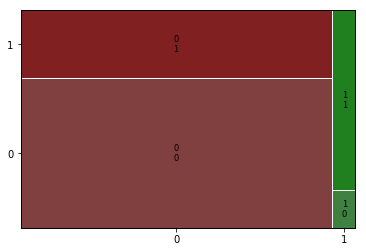

In [56]:
# extract best model
best_model = grid_rfc.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_res, y_res)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(auc)
#fpr = false positive rate, tpr = true positive rate

0.758092738407699


Text(0, 0.5, 'True Positive Rate')

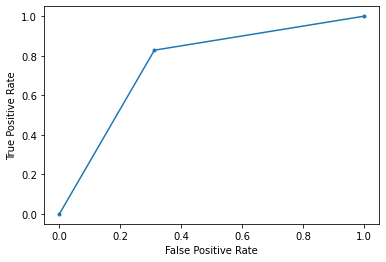

In [58]:
plt.plot(fpr, tpr, marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [59]:
# better here because the data is imbalanced
from sklearn.metrics import precision_recall_curve, f1_score, auc 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

f1 = f1_score(y_test, y_pred)
print(f1)

auc = auc(recall, precision)
print(auc)

0.26580226904376014
0.4989738114738115


Text(0, 0.5, 'Precision')

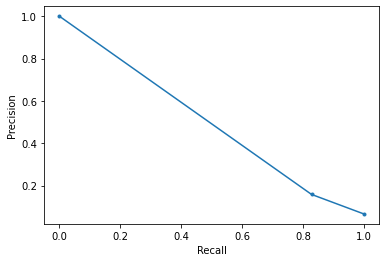

In [60]:
plt.plot(recall, precision, marker = '.')
plt.xlabel('Recall')
plt.ylabel('Precision')

## AdaBoost with Random Oversample

In [61]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=42)

#define a grid of hyperparameters
params_ada = {
    'n_estimators': [50,100,300],
    'learning_rate': [.5,.7,1],
}

# instantiate grid_rfc
grid_ada = GridSearchCV(estimator=ada,
                        param_grid=params_ada,
                       cv=3,
                       scoring= 'accuracy',
                       verbose=1,
                       n_jobs=-1)
# fit grid_rfc to training set
grid_ada.fit(X_res, y_res)
#extract best hyperparameters

best_hyperparams = grid_ada.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best hyperparameters:
 {'learning_rate': 1, 'n_estimators': 300}


In [62]:
# extract best model
best_model = grid_ada.best_estimator_
#predict the test set labels
y_pred = best_model.predict(X_test)

best_accuracy_train = best_model.score(X_res, y_res)
best_accuracy = best_model.score(X_test, y_test)
print('Train set accuracy score of rfc: ' + str(best_accuracy_train))
print('Test set accuracy score of rfc: ' + str(best_accuracy))

#print(classification_report(y_test, y_pred))
from imblearn.metrics import classification_report_imbalanced
print('')
print(classification_report_imbalanced(y_test, y_pred))

Train set accuracy score of rfc: 0.8385864374403056
Test set accuracy score of rfc: 0.7713903743315508

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.78      0.60      0.86      0.68      0.48      1397
          1       0.16      0.60      0.78      0.26      0.68      0.46        99

avg / total       0.91      0.77      0.61      0.82      0.68      0.47      1496



In [63]:
print(confusion_matrix(y_test, y_pred))

[[1095  302]
 [  40   59]]


(<Figure size 432x288 with 3 Axes>,
 {('0', '0'): (0.0, 0.0, 0.9291776412057361, 0.7812184153513579),
  ('0', '1'): (0.0,
   0.7845406744875706,
   0.9291776412057361,
   0.2154593255124293),
  ('1', '0'): (0.9341527655838456,
   0.0,
   0.06584723441615452,
   0.4026980771166817),
  ('1', '1'): (0.9341527655838456,
   0.40602033625289435,
   0.06584723441615452,
   0.5939796637471056)})

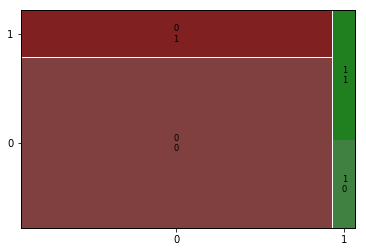

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)

mosaic(conf_matrix)